
# 주제 : Seq2Seq로 네이버 영화 긍부정 평가하기
--------------
## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## 데이터 소개
    - 이번 주제는 Naver sentiment movie corpus 데이터를 사용합니다.
    - Naver sentiment movie corpus Dataset은 20만개의 영화 리뷰를 기록해둔 데이터 셋입니다.
    - 모든 데이터는 작성자 id, 리뷰, 긍부정 여부로 되어있습니다.
    - 긍부정 여부는 0,1의 값을 가집니다.
    - 리뷰의 길이는 140자를 넘지 않습니다.
    - 긍부정 비율은 약 50% 내외입니다.
    - 학습 데이터와 정답 데이터는, 각각의 아래와 같습니다.
    
    1. ratings_train
      0	9976970	아 더빙.. 진짜 짜증나네요 목소리	0
      1	3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
      2	10265843	너무재밓었다그래서보는것을추천한다	0
      3	9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
      4	6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...	1
    
    2. ratings_test
      6270596	굳 ㅋ	1
      9274899	GDNTOPCLASSINTHECLUB	0
      8544678	뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아	0
      6825595	지루하지는 않은데 완전 막장임... 돈주고 보기에는....	0

    
- 데이터 출처: [nsmc](https://github.com/e9t/nsmc)


## 최종 목표
    - Seq2Seq 기반 모델의 이해
    - word embedding 이해
    - 시계열 데이터 학습 이해
    
  - 출제자 : 손근영 강사


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## Step 1. 도입전 기본 처리

### 문제 1. 네이버 데이터 다운 받기

In [2]:
# 데이터를 불러오는 코드를 작성해주세요.
# https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
# https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt

In [3]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2021-06-07 12:06:54--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Saving to: ‘ratings_test.txt’

ratings_test.txt    100%[===================>]   4.67M  --.-KB/s    in 0.06s   

2021-06-07 12:06:55 (79.4 MB/s) - ‘ratings_test.txt’ saved [4893335/4893335]



In [4]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt

--2021-06-07 12:06:55--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  --.-KB/s    in 0.1s    

2021-06-07 12:06:55 (121 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]



### 문제 2. 네이버 데이터 판다스 데이터프레임에 로드하기

In [5]:
# 데이터를 불러오는 코드를 작성해주세요.
train_df = pd.read_csv('ratings_train.txt', sep='\t')
test_df =pd.read_csv('ratings_test.txt', sep='\t')

In [6]:
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 문제 3. train_df/test_df의 shape/dtype을 출력해보세요.

In [7]:
# 데이터의 크기를 shape 함수를 통해 출력해주세요.
print(train_df.shape, test_df.shape)

(150000, 3) (50000, 3)


In [8]:
# train_text/topic의 dtype을 출력해보세요.
print(train_df.dtypes, test_df.dtypes, sep='\n\n')

id           int64
document    object
label        int64
dtype: object

id           int64
document    object
label        int64
dtype: object


### 문제 4. train_df에서 각 원소의 길이를 y축으로 bar plot를 그려보세요.

## pandas.DataFrame.sample
DataFrame.sample(n=None, frac=None, replace=False, weights=None, random_state=None, axis=None)<br>

Return a random sample of items from an axis of object.

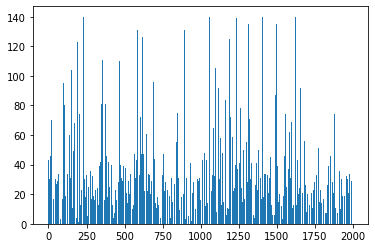

In [9]:
# train_text에서 각 원소의 길이를 y축으로 bar plot를 그려보세요.
plt.bar( np.array(range(2000)), [len(str(text)) for text in train_df.sample(n=2000).document] )
# plt.bar( np.array(range(2000)), [len(str(text)) for text in train_df.document[:2000]] )
plt.show()

## Step 2. 전처리

### 문제 5. 형태소 분석기 설치

In [10]:
# 형태소 분석기 설치
!pip install konlpy

     |████████████████████████████████| 19.4MB 155kB/s 
     |████████████████████████████████| 92kB 13.1MB/s 
     |████████████████████████████████| 460kB 51.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [11]:
from konlpy.tag import Okt

In [12]:
okt = Okt()
list(filter(lambda x: x[1] == 'Noun', okt.pos("오늘은 즐겁게 딥러닝 공부를 하고 있습니다.")))

[('오늘', 'Noun'), ('딥', 'Noun'), ('러닝', 'Noun'), ('공부', 'Noun')]

### 문제 6. sentencepiece 설치 및 data 학습

In [13]:
# sentencepiece 설치 및 data 학습
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 34.4MB/s 


In [14]:
import sentencepiece as spm

In [15]:
full_document = np.concatenate([train_df.document.values, test_df.document.values])
full_document.shape

(200000,)

In [16]:
with open('./full_docu.txt', 'w', encoding='utf-8') as f:
    for line in full_document:
        if len(str(line).strip()) == 0: continue
        try:
            f.write(line +'\n')
        except: continue

In [17]:
spm.SentencePieceTrainer.train('--input=full_docu.txt --model_prefix=m --vocab_size=20000')

### 문제 7. sentencepiece 모델 로드 및 텍스트 분석


In [18]:
# sentencepiece 모델 로드 및 텍스트 분석
sp = spm.SentencePieceProcessor()
sp.load('./m.model')

True

In [19]:
sp.encode_as_pieces("오늘은 즐겁게 딥러닝 공부를 하고 있습니다.")

['▁오늘', '은', '▁즐겁게', '▁', '딥', '러', '닝', '▁공부', '를', '▁하고', '▁있습니다', '.']

### 문제 8-1. 텍스트 id로 인코딩 및 디코딩

In [20]:
# 텍스트 id로 인코딩
sp.encode_as_ids("오늘은 즐겁게 딥러닝 공부를 하고 있습니다.")

[605, 17, 2634, 4, 19433, 320, 3864, 2747, 23, 306, 2100, 3]

In [21]:
# 텍스트 id로 디코딩
sp.decode_ids([605, 17, 2634, 4, 19433, 320, 3864, 2747, 23, 306, 2100, 3])

'오늘은 즐겁게 딥러닝 공부를 하고 있습니다.'

In [22]:
sp.decode_pieces(['▁오늘', '은', '▁즐겁게', '▁', '딥', '러', '닝', '▁공부', '를', '▁하고', '▁있습니다', '.'])

'오늘은 즐겁게 딥러닝 공부를 하고 있습니다.'

### 문제 8-2. sentencepiece로 train/test document 필드 분석 후 저장

In [23]:
# sentencepiece로 train/test document 필드 분석 후 저장
train_df['bow'] = train_df.document.apply(lambda x: sp.encode_as_ids(str(x)))

In [24]:
test_df['bow'] = test_df.document.apply(lambda x: sp.encode_as_ids(str(x)))

In [25]:
train_df.head()

,id,document,label,bow
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,"[55, 992, 5, 26, 15918, 1228]"
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,"[1494, 6, 4134, 162, 1679, 34, 368, 50, 15251,..."
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[18, 493, 19794, 543, 3006, 13489, 14, 2172, 292]"
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[14221, 200, 6985, 4, 5, 3718, 949, 90, 5, 690..."
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[3044, 5637, 1831, 235, 9, 18574, 2081, 330, 1..."


### 문제 9. 형태소 분석기로 document 필드 분석

In [26]:
# 형태소 분석기로 document 필드 분석
# train_df['tag'] = train_df.document.apply(lambda x: okt.pos(str(x)))//

### 문제 10. train/test 에 대한 x, y 데이터를 만들어보자 (train_text, train_sentiment, test...)

In [27]:
# train/test 에 대한 x, y 데이터 생성
train_text = train_df.bow.values
test_text = test_df.bow.values

In [28]:
train_text

array([list([55, 992, 5, 26, 15918, 1228]),
       list([1494, 6, 4134, 162, 1679, 34, 368, 50, 15251, 416, 1336, 8263, 876, 441]),
       list([18, 493, 19794, 543, 3006, 13489, 14, 2172, 292]), ...,
       list([103, 149, 59, 15, 3661, 17, 341, 68, 948, 10297, 4517, 73, 7867, 4423, 3748, 17, 16822, 20, 15]),
       list([2323, 398, 4800, 3, 483, 2425, 33, 3147, 388, 734, 360, 17722]),
       list([263, 7, 3519, 30, 46, 570, 60, 304, 5016, 7])], dtype=object)

In [29]:
train_sentiment = train_df.label.values
test_sentiment = test_df.label.values

In [30]:
train_sentiment

array([0, 1, 0, ..., 0, 1, 0])

### 문제 11. train_text, test_text에서 등장한 정수들을 알아보자

In [31]:
# train_text, test_text에서 등장한 정수들을 알아보자
all_words = set([id for ids in train_text for id in ids]) | set([id for ids in test_text for id in ids])

In [32]:
print(sorted(all_words)[:5])
print(sorted(all_words)[-5:])

[0, 3, 4, 5, 6]
[19995, 19996, 19997, 19998, 19999]


### 문제 12. train_text와 test_text를 BOW 형태로 변경

In [33]:
# train_text와 test_text를 BOW 형태로 변경하세요.
train_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_text, value=0)
test_bow_text = tf.keras.preprocessing.sequence.pad_sequences(test_text, value=0)

In [34]:
train_bow_text.shape, test_bow_text.shape

((150000, 132), (50000, 107))

### 문제 13. train과 test에 나온 word들의 count를 측정해보자

In [35]:
# train과 test에 나온 word들의 count를 측정해보자
from collections import Counter
word_count = Counter()

for text in train_text:
    word_count.update(text)
for text in test_text:
    word_count.update(text)

In [36]:
word_count.most_common(10)

[(3, 92725),
 (4, 48120),
 (5, 40816),
 (6, 33568),
 (7, 30107),
 (10, 24225),
 (9, 24211),
 (8, 23664),
 (11, 20862),
 (12, 19666)]

### 문제 14. word_count를 이용해서 n번 이하로 나온 word를 삭제하여 train과 test를 구성하여보자.

In [37]:
# word_count를 이용해서 n번 미만으로 나온 word를 삭제하여 train과 test를 구성하여보자.
def cut_by_count(texts, n):
    return np.array([[word for word in text if word_count[word] > n ]for text in texts])

In [38]:
train_cut_text = cut_by_count(train_text,20)
test_cut_text = cut_by_count(test_text,20)

In [39]:
train_cut_text.shape, test_cut_text.shape

((150000,), (50000,))

### 문제 15. pad 추가된 bow 형태로 변화하여 width 길이를 확인해보세요.

In [40]:
# bow 형태로 변화하여 width 길이를 확인해보세요.
train_cut_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_cut_text, value=0)
test_cut_bow_text = tf.keras.preprocessing.sequence.pad_sequences(test_cut_text, value=0)

In [41]:
train_cut_bow_text.shape, test_cut_bow_text.shape

((150000, 132), (50000, 106))

### 문제 16. train_text/test_text에 길이 제한을 줘서 bow를 생성해보세요.

In [42]:
# train_text/test_text에 길이 제한을 줘서 bow를 생성해보세요.
train_cut_bow_text2 = tf.keras.preprocessing.sequence.pad_sequences(train_cut_text, value=0, maxlen=100)
test_cut_bow_text2 = tf.keras.preprocessing.sequence.pad_sequences(test_cut_text, value=0, maxlen=100)

In [43]:
train_cut_bow_text2.shape, test_cut_bow_text2.shape

((150000, 100), (50000, 100))

### 문제 17. sentiment을 onehot encoding으로 변경해보세요.

In [44]:
# sentiment을 onehot encoding으로 변경해보세요.
np.unique(train_sentiment), np.unique(test_sentiment)

(array([0, 1]), array([0, 1]))

In [45]:
train_one_hot_sentiment = tf.keras.utils.to_categorical(train_sentiment)
test_one_hot_sentiment = tf.keras.utils.to_categorical(test_sentiment)

In [46]:
train_one_hot_sentiment.shape, test_one_hot_sentiment.shape

((150000, 2), (50000, 2))

### 문제 18. sentiment 인덱스를 text label로 변환하는 함수를 만드세요.

In [61]:
#sentiment 인덱스를 text label로 변환하는 함수를 만드세요.
raw_labels=['bad', 'good']

def sentiment2label(idx):
    return raw_labels[idx]

sentiment2label(0)

'bad'

## Step 3. 시각화 방법

### 문제 19. train_bow_text의 길이 분포를 출력해보세요.

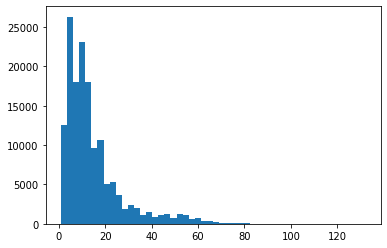

In [48]:
# train_bow_text의 길이 분포를 출력해보세요.
plt.hist( [len(s) for s in train_text] , bins =50)
plt.show()

### 문제 20. train_cut_bow_text의 길이 분포를 출력해보세요.

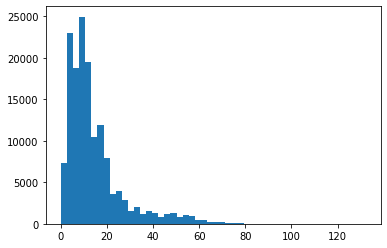

In [52]:
# train_bow_text의 길이 분포를 출력해보세요.
plt.hist ( [len(s) for s in train_cut_text], bins=50)
plt.show()

### 문제 21. train_cut_bow_text2의 길이 분포를 출력해보세요.

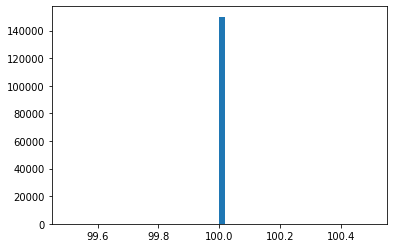

In [54]:
# train_cut_bow_text2의 길이 분포를 출력해보세요.
plt.hist( [len(s) for s in train_cut_bow_text2], bins=50)
plt.show()

### 문제 22. label 분포를 출력해보세요.

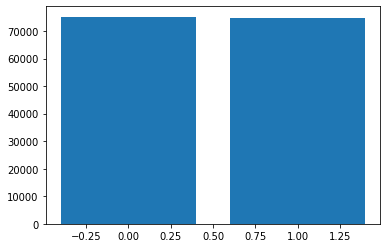

In [56]:
# label 분포를 출력해보세요.
plt.bar(np.unique(train_sentiment), list(map(lambda x: x[1], sorted(Counter(train_sentiment).items()))))
plt.show()

### 문제 23. seabon을 이용하여 label 분포를 출력해보세요.

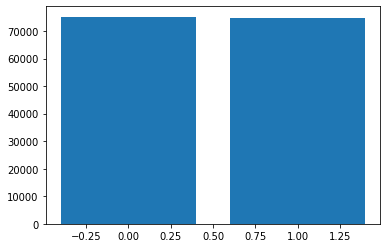

In [57]:
# label 분포를 출력해보세요.
plt.bar(*np.unique(train_sentiment, return_counts=True))
plt.show()

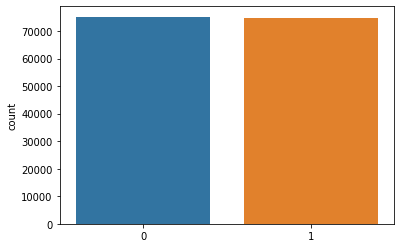

In [59]:
sns.countplot(train_sentiment)
plt.show()

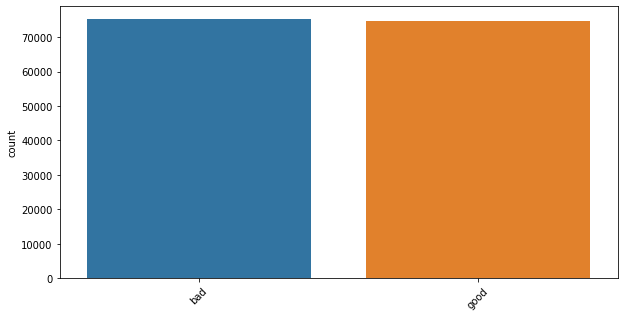

In [64]:
sns.countplot(list(map(lambda x: sentiment2label(x), train_sentiment)))
plt.xticks(rotation=45)
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

### 문제 24. sp를 이용해서 text를 decode해보세요.

In [65]:
# sp를 이용해서 text를 decode해보세요.
def bow2text(bow):
    return sp.decode_ids(bow)

In [67]:
test_text, bow2text(test_text[0])

(array([list([1351, 196]),
        list([5513, 1077, 4194, 2310, 3099, 4528, 2464, 4369, 2349, 2073, 2073, 17039, 17997, 2464, 4369, 5008, 2588]),
        list([901, 25, 64, 479, 50, 11790, 2654, 56, 35, 5400, 13, 8961, 4834]),
        ...,
        list([2362, 11, 454, 2031, 11, 13109, 95, 6, 104, 291, 4885, 123, 2151]),
        list([442, 980, 13, 53, 643, 7, 5, 445, 156, 9885, 1808, 1171, 5, 75, 19257, 49, 44, 418, 948, 58]),
        list([1773, 13, 147, 3267])], dtype=object), '굳 ᄏ')

### 문제 25. train/test 데이터에서 문서당 가장 많은 횟수로 출현한 word 분포를 출력하세요.

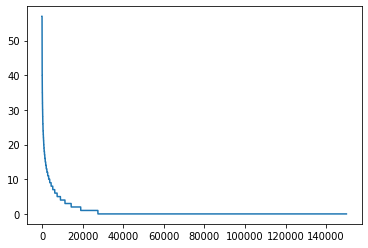

In [70]:
# 문서당 가장 많은 횟수로 출현한 word 분포를 출력하세요.
plt.plot(sorted([np.unique(doc, return_counts=True)[1].argmax() for doc in train_text], reverse=True ))
plt.show()

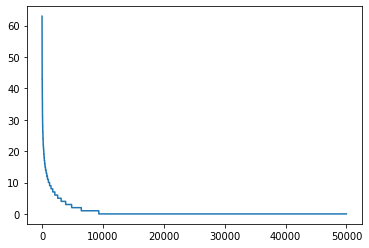

In [71]:
plt.plot(sorted([np.unique(doc, return_counts=True)[1].argmax() for doc in test_text], reverse=True ))
plt.show()

### 문제 26. train/test 전체 문서 당 출현이 가장 높은 word 분포를 출력하세요.

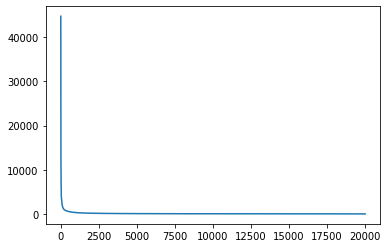

In [73]:
# train/test 전체 문서 당 출현이 가장 높은 word 분포를 출력
table = np.zeros(len(all_words)+2)
for doc in train_text:
    table[np.unique(doc)]+=1
plt.plot(sorted(table, reverse=True))
plt.show()

## Step 4. Seq2Seq의 Encoder 이용 모델링

### 문제 27. Encoder이용 classification 모델 구축

In [79]:
# seq2seq 모델을 구축하고 학습모델, encoder를 획득하세요
from keras.models import Model
from keras.layers import Input, Dense, GRU, Embedding

def Seq2Seq():
    inputs_x_bow = Input(shape=(100,))
    embedding = Embedding(20000, 120)
    x = embedding(inputs_x_bow)
    z = GRU(64)(x)
    y = Dense(2, activation='softmax')(z)

    model = Model(inputs_x_bow, y)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

### 문제 28. 학습 모델을 생성하고 summary를 출력하세요. 

In [80]:
# 학습 모델을 생성하고 summary를 출력하세요.
model = Seq2Seq()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 120)          2400000   
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                35712     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 2,435,842
Trainable params: 2,435,842
Non-trainable params: 0
_________________________________________________________________


### 문제 29. 모델을 학습해보세요.

In [82]:
# 학습모델을 학습해보세요.
hist = model.fit(
    train_cut_bow_text2,
    train_one_hot_sentiment,
    validation_data=(test_cut_bow_text2, test_one_hot_sentiment),
    verbose = 1,
    epochs=2
)

Epoch 1/2
4688/4688 [==============================] - 129s 27ms/step - loss: 0.3374 - acc: 0.8524 - val_loss: 0.3177 - val_acc: 0.8614
Epoch 2/2
4688/4688 [==============================] - 128s 27ms/step - loss: 0.2499 - acc: 0.8953 - val_loss: 0.3241 - val_acc: 0.8618


### 문제 30. 학습 진행 사항을 plt으로 출력하세요.

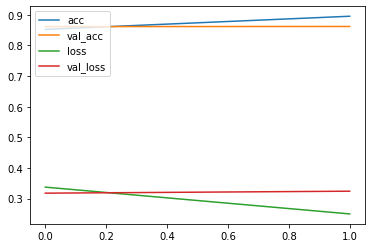

In [84]:
# hist의 accuracy와 loss를 plt의 plot을 이용하여 출력하는 코드를 작성하세요
plt.plot(hist.history['acc'], label='acc')
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

### 문제 31. train_cut_bow_text를 위한 학습 모델을 생성하고 summary를 출력하세요. 

In [86]:
# 학습 모델을 생성하고 summary를 출력하세요.
model2 = Seq2Seq()
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 120)          2400000   
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                35712     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 2,435,842
Trainable params: 2,435,842
Non-trainable params: 0
_________________________________________________________________


### 문제 32. 학습모델을 학습해보세요. 단, train_cut_bow_text를 100으로 길이를 수정하고 실행하세요.

In [89]:
# 학습모델을 학습해보세요.
hist2 = model2.fit(
    train_cut_bow_text[...,-100:],
    train_one_hot_sentiment,
    validation_data=(test_cut_bow_text[...,-100:], test_one_hot_sentiment),
    verbose = 2,
    epochs=2
)

Epoch 1/2
4688/4688 - 117s - loss: 0.2566 - acc: 0.8930 - val_loss: 0.3275 - val_acc: 0.8610
Epoch 2/2
4688/4688 - 115s - loss: 0.1967 - acc: 0.9191 - val_loss: 0.3552 - val_acc: 0.8544


### 문제 33. 학습 진행 사항을 plt으로 출력하세요.

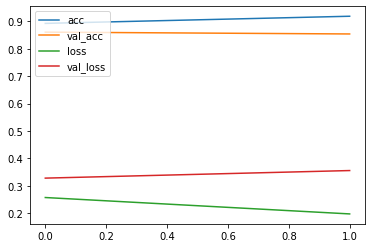

In [90]:
# hist2의 accuracy와 loss를 plt의 plot을 이용하여 출력하는 코드를 작성하세요
plt.plot(hist2.history['acc'], label='acc')
plt.plot(hist2.history['val_acc'], label='val_acc')
plt.plot(hist2.history['loss'], label='loss')
plt.plot(hist2.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

## Step 5. 모델 결과 확인

### 문제 34. 완성된 모델1, 2에서 test 하나를 예측하고 결과를 res1, res2 변수에 저정하세요.

In [106]:
# 완성된 모델에서 test 하나를 예측하고 결과를 res 변수에 저정하세요.
res1 = model.predict(test_cut_bow_text2[0:1])
res1

array([[0.01497435, 0.9850256 ]], dtype=float32)

In [105]:
res2 = model2.predict(test_cut_bow_text[0:1,-100:])
res2

array([[0.06174659, 0.93825334]], dtype=float32)

In [143]:
res = model.predict(test_cut_bow_text[:10])
res.argmax(axis=1)

array([1, 1, 0, 0, 1, 1, 0, 0, 0, 1])

### 문제 35. res1, res2의 결과를 확인하세요.

In [110]:
test_sentiment[0]
test_one_hot_sentiment

1

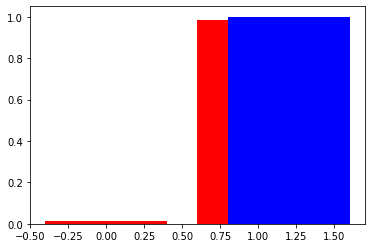

'good'

In [118]:
# res1, res2의 결과를 확인하세요.
plt.bar(np.array([0,1]), res1[0], color='red')
plt.bar(np.array([0,1])+0.2, test_one_hot_sentiment[0], color='blue')
plt.show()
sentiment2label(res1[0].argmax())

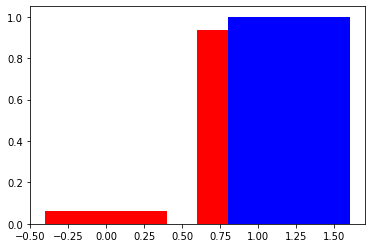

'good'

In [119]:
plt.bar(np.array([0,1]), res2[0], color='red')
plt.bar(np.array([0,1])+0.2, test_one_hot_sentiment[0], color='blue')
plt.show()
sentiment2label(res2[0].argmax())

### 문제 36. 평문을 bow로 변환해보세요. 

In [122]:
# 평문을 bow로 변환해보세요. (oov는 무시합니다.)
text = bow2text(test_text[2])
def text2bow(text, maxlen = 150):
    seq = sp.encode_as_ids(text)
    bow = tf.keras.preprocessing.sequence.pad_sequences([seq], value=0, maxlen=maxlen)
    return bow

In [125]:
text2bow('뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아')

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [126]:
mytext = text2bow('이 영화는 신이내린 감동의 영화입니다')

In [127]:
mytext.shape

(1, 150)

### 문제 37. text2bow를 이용하여 model1을 통해 결과를 확인하세요.

In [129]:
# text2bow를 이용하여 model1을 통해 결과를 확인
res3 = model.predict(mytext[...,-100:])
res3

array([[0.3755664, 0.6244336]], dtype=float32)

In [131]:
res4 = model.predict(text2bow('이 영화는 악마가 내린 최악의 영화입니다')[...,-100:])
res4

array([[0.9973084 , 0.00269162]], dtype=float32)

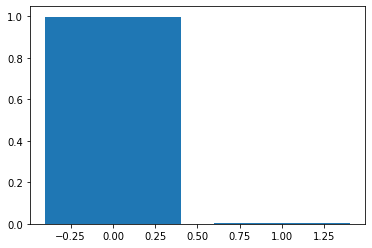

In [133]:
plt.bar([0,1], res4[0])
plt.show()

### 문제 38. cut_by_count를 이용하여 20회 이상 등장한 word만 사용하는 bow를 만들어보세요

In [138]:
# cut_by_count를 이용하여 20회 이상 등장한 word만 사용하는 bow를 만들어보세요
bow1_cut = tf.keras.preprocessing.sequence.pad_sequences(cut_by_count(mytext, 20), maxlen = 100, value=0)
bow1_cut

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,    25,    76,  6918, 12791,  3652,
          447]], dtype=int32)

In [136]:
sp.decode_ids([25,76,6918,12791,3652,447])

'이 영화는 신이내린 감동의 영화입니다'

### 문제 39. text2bow를 이용하여 model2을 통해 결과를 확인하세요.


In [139]:
# text2bow를 이용하여 model1을 통해 결과를 확인
model2.predict(bow1_cut)

array([[0.4170798 , 0.58292025]], dtype=float32)

### 문제 40. confusion 매트릭스 생성

In [140]:
# confusion 메트릭스 출력
from sklearn.metrics import confusion_matrix
conf_mat1 = confusion_matrix(test_one_hot_sentiment.argmax(axis=1), model.predict(test_cut_bow_text2).argmax(axis=1))
print(conf_mat1)

[[20926  3901]
 [ 3007 22166]]


In [141]:
conf_mat2 = confusion_matrix(test_one_hot_sentiment.argmax(axis=1), model2.predict(test_cut_bow_text[...,-100:]).argmax(axis=1))
print(conf_mat2)

[[22005  2822]
 [ 4458 20715]]


### 문제 41. confusion 매트릭스 시각화

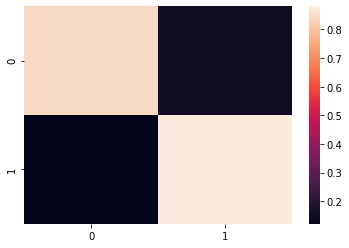

In [147]:
# confusion 매트릭스 시각화
sns.heatmap(conf_mat1 / conf_mat1.sum(axis=1))
plt.show()

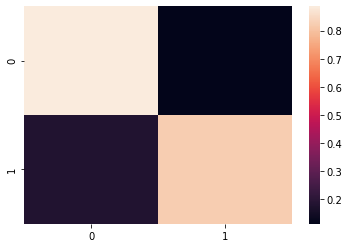

In [146]:
sns.heatmap(conf_mat2 / conf_mat2.sum(axis=1))
plt.show()

### 문제 42. classification 결과 리포팅

In [148]:
# classification 결과 리포팅
from sklearn.metrics import classification_report

In [149]:
print(classification_report(test_one_hot_sentiment.argmax(axis=1), model.predict(test_cut_bow_text2).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86     24827
           1       0.85      0.88      0.87     25173

    accuracy                           0.86     50000
   macro avg       0.86      0.86      0.86     50000
weighted avg       0.86      0.86      0.86     50000



In [151]:
print(classification_report(test_one_hot_sentiment.argmax(axis=1), model2.predict(test_cut_bow_text[...,-100:]).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86     24827
           1       0.88      0.82      0.85     25173

    accuracy                           0.85     50000
   macro avg       0.86      0.85      0.85     50000
weighted avg       0.86      0.85      0.85     50000



## Step 6. 모델 저장 및 로드, 다운

### 문제 43. 모델을 저장하세요.

In [152]:
# 모델을 저장하는 코드를 작성하세요. 
model.save('./seq2seq.h5')

### 문제 44. 모델 파일을 새로운 모델에 로드하세요.

In [153]:
# 모델을 로드하는 코드를 작성하세요.
new_model = tf.keras.models.load_model('./seq2seq.h5')

### 문제 45. 로드한 모델을 test 데이터로 평가해보세요.


In [154]:
# 로드한 모델을 test 데이터로 평가해보세요.
new_model.evaluate(test_cut_bow_text2, test_one_hot_sentiment)

1563/1563 [==============================] - 6s 4ms/step - loss: 0.3241 - acc: 0.8618


[0.3240745961666107, 0.861840009689331]

### 문제 46. 모델을 내 컴퓨터에 저장해보세요

In [ ]:
# 모델을 내 컴퓨터에 저장해보세요.